In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import os
if not os.path.isdir('figures'):
    os.makedirs('figures')

In [2]:
epochs = 1500
batch_size = 8
num_neurons = 10
seed = 10

beta = 1e-3
alpha = 1e-3

l2=keras.regularizers.l2(beta)
sgd=keras.optimizers.SGD(learning_rate=alpha)

histories={}

np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
#read and divide data into test and train sets 
admit_data = np.genfromtxt('admission_predict.csv', delimiter= ',')
X_data, Y_data = admit_data[1:,1:8], admit_data[1:,-1]
Y_data = Y_data.reshape(Y_data.shape[0], 1)

X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_data,test_size = 0.3, random_state = seed, shuffle=True)

#Preprocess by standardizing the Xtrain and Xtest based on Xtrain stats
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [4]:
train_data_6_feature = []
test_data_6_feature = []

#Make train and test set for 6 features RFE.
for feature_idx in range(7):
    temp = np.delete(X_train,obj=feature_idx,axis=1)
    train_data_6_feature.append(temp)
    temp = np.delete(X_test,obj=feature_idx,axis=1)
    test_data_6_feature.append(temp)
    
#keep model with lowest m.s.e (model that removed feature 6 Research has lowest average test mse)
X6_train, X6_test = train_data_6_feature[6],test_data_6_feature[6]

In [5]:
train_data_5_feature = []
test_data_5_feature = []

#Make train and test set for 5 features RFE.
for feature_idx in range(6):
    temp = np.delete(X6_train,obj=feature_idx,axis=1)
    train_data_5_feature.append(temp)
    temp = np.delete(X6_test,obj=feature_idx,axis=1)
    test_data_5_feature.append(temp)
    
#Keep model with lowest MSE (from removing the feature 3 or SOP)
X5_train, X5_test = train_data_5_feature[3],test_data_5_feature[3]

In [6]:
print(X6_train)

[[ 1.42832554  1.60033916  0.81007205  1.61476636  0.63111055  1.75693791]
 [ 2.03141     2.09401705  1.68922001  1.12224503  1.17990233  1.65722655]
 [-1.07016722 -0.86805029 -0.94822387 -0.35531896  0.63111055  0.21141182]
 ...
 [-0.20861799 -0.3743724  -0.06907591  0.13720237 -1.0152648  -0.50318626]
 [-1.41478691 -1.19716888 -0.06907591 -1.34036162 -0.46647302  0.0950819 ]
 [-0.29477291 -0.86805029 -0.06907591 -0.84784029 -1.0152648   0.12831902]]


In [7]:
print(X5_train)

[[ 1.42832554  1.60033916  0.81007205  0.63111055  1.75693791]
 [ 2.03141     2.09401705  1.68922001  1.17990233  1.65722655]
 [-1.07016722 -0.86805029 -0.94822387  0.63111055  0.21141182]
 ...
 [-0.20861799 -0.3743724  -0.06907591 -1.0152648  -0.50318626]
 [-1.41478691 -1.19716888 -0.06907591 -0.46647302  0.0950819 ]
 [-0.29477291 -0.86805029 -0.06907591 -1.0152648   0.12831902]]


In [8]:
print(X6_test)

[[-0.72554753 -0.2098131  -0.06907591  0.13720237 -1.0152648  -0.6527533 ]
 [ 0.39446647  0.28386479  0.81007205  0.6297237   0.63111055  0.12831902]
 [-1.15632214 -1.19716888 -0.94822387 -0.35531896  0.08231877 -0.9020317 ]
 [-1.84556153 -1.36172818 -0.94822387 -0.84784029 -0.46647302 -1.58339266]
 [-0.03630815 -0.86805029 -0.06907591 -1.34036162 -0.46647302 -1.99885666]
 [-0.46708276 -1.36172818 -1.82737184 -0.84784029 -0.46647302 -0.28714498]
 [ 2.03141     2.09401705  0.81007205  1.61476636  1.72869412  1.49104095]
 [ 1.2560157   1.60033916  0.81007205  1.12224503  1.72869412  1.35809247]
 [ 1.2560157   1.27122056  1.68922001  0.6297237   0.08231877  1.39132959]
 [-0.9840123   0.11930549  1.68922001 -0.35531896 -0.46647302 -0.20405218]
 [ 0.91139601 -0.5389317   1.68922001 -0.35531896  0.08231877  0.39421598]
 [ 0.48062139  0.44842408  0.81007205  0.6297237   1.72869412  0.87615422]
 [ 0.39446647  0.28386479 -0.06907591 -0.35531896 -0.46647302 -0.10434082]
 [-0.12246307 -1.19716888

In [9]:
print(X5_test)

[[-0.72554753 -0.2098131  -0.06907591 -1.0152648  -0.6527533 ]
 [ 0.39446647  0.28386479  0.81007205  0.63111055  0.12831902]
 [-1.15632214 -1.19716888 -0.94822387  0.08231877 -0.9020317 ]
 [-1.84556153 -1.36172818 -0.94822387 -0.46647302 -1.58339266]
 [-0.03630815 -0.86805029 -0.06907591 -0.46647302 -1.99885666]
 [-0.46708276 -1.36172818 -1.82737184 -0.46647302 -0.28714498]
 [ 2.03141     2.09401705  0.81007205  1.72869412  1.49104095]
 [ 1.2560157   1.60033916  0.81007205  1.72869412  1.35809247]
 [ 1.2560157   1.27122056  1.68922001  0.08231877  1.39132959]
 [-0.9840123   0.11930549  1.68922001 -0.46647302 -0.20405218]
 [ 0.91139601 -0.5389317   1.68922001  0.08231877  0.39421598]
 [ 0.48062139  0.44842408  0.81007205  1.72869412  0.87615422]
 [ 0.39446647  0.28386479 -0.06907591 -0.46647302 -0.10434082]
 [-0.12246307 -1.19716888 -1.82737184 -1.0152648  -1.08483586]
 [ 1.68679031  1.92945775  1.68922001  0.08231877  1.98959775]
 [ 1.08370585  0.94210197  1.68922001  1.17990233  1.40

In [10]:
# build_fn for sklearn wrapped
def get_baseline_model(input_size):
    model = keras.Sequential()
    model.add(keras.layers.Dense(num_neurons, input_dim = input_size, activation='relu',kernel_regularizer=l2))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer=sgd,
                  loss=keras.losses.MeanSquaredError(),
                  metrics=['mse'])
    
    return model

In [11]:
csv_logger_base = keras.callbacks.CSVLogger('base_model.csv')
csv_logger_6 = keras.callbacks.CSVLogger('6_model.csv')
csv_logger_5 = keras.callbacks.CSVLogger('5_model.csv')
early_stopper = keras.callbacks.EarlyStopping(monitor='val_mse',patience=10,mode="min",min_delta=1e-5)

In [12]:
#full train until overfitting
input_size = X_train.shape[1]
model = get_baseline_model(input_size)
results = model.fit(X_train,Y_train, validation_data = (X_test, Y_test),
                   epochs=epochs, batch_size=batch_size, verbose=2,callbacks=[csv_logger_base])

Epoch 1/1500
35/35 - 0s - loss: 0.5108 - mse: 0.5020 - val_loss: 0.4435 - val_mse: 0.4348
Epoch 2/1500
35/35 - 0s - loss: 0.4330 - mse: 0.4243 - val_loss: 0.3804 - val_mse: 0.3717
Epoch 3/1500
35/35 - 0s - loss: 0.3729 - mse: 0.3642 - val_loss: 0.3309 - val_mse: 0.3223
Epoch 4/1500
35/35 - 0s - loss: 0.3256 - mse: 0.3170 - val_loss: 0.2915 - val_mse: 0.2829
Epoch 5/1500
35/35 - 0s - loss: 0.2874 - mse: 0.2788 - val_loss: 0.2596 - val_mse: 0.2510
Epoch 6/1500
35/35 - 0s - loss: 0.2566 - mse: 0.2479 - val_loss: 0.2337 - val_mse: 0.2251
Epoch 7/1500
35/35 - 0s - loss: 0.2313 - mse: 0.2227 - val_loss: 0.2123 - val_mse: 0.2038
Epoch 8/1500
35/35 - 0s - loss: 0.2104 - mse: 0.2018 - val_loss: 0.1944 - val_mse: 0.1858
Epoch 9/1500
35/35 - 0s - loss: 0.1927 - mse: 0.1841 - val_loss: 0.1792 - val_mse: 0.1706
Epoch 10/1500
35/35 - 0s - loss: 0.1776 - mse: 0.1690 - val_loss: 0.1661 - val_mse: 0.1576
Epoch 11/1500
35/35 - 0s - loss: 0.1647 - mse: 0.1562 - val_loss: 0.1551 - val_mse: 0.1466
Epoch 12

In [13]:
#6 features train until overfitting
input_size = X6_train.shape[1]
model_6 = get_baseline_model(input_size)
results_6 = model_6.fit(X6_train,Y_train, validation_data = (X6_test, Y_test),
                   epochs=epochs, batch_size=batch_size, verbose=2,callbacks=[csv_logger_6])

Epoch 1/1500
35/35 - 0s - loss: 0.2232 - mse: 0.2162 - val_loss: 0.2227 - val_mse: 0.2157
Epoch 2/1500
35/35 - 0s - loss: 0.2115 - mse: 0.2045 - val_loss: 0.2146 - val_mse: 0.2076
Epoch 3/1500
35/35 - 0s - loss: 0.2031 - mse: 0.1961 - val_loss: 0.2079 - val_mse: 0.2009
Epoch 4/1500
35/35 - 0s - loss: 0.1960 - mse: 0.1890 - val_loss: 0.2018 - val_mse: 0.1949
Epoch 5/1500
35/35 - 0s - loss: 0.1897 - mse: 0.1828 - val_loss: 0.1960 - val_mse: 0.1890
Epoch 6/1500
35/35 - 0s - loss: 0.1839 - mse: 0.1770 - val_loss: 0.1903 - val_mse: 0.1834
Epoch 7/1500
35/35 - 0s - loss: 0.1783 - mse: 0.1714 - val_loss: 0.1847 - val_mse: 0.1778
Epoch 8/1500
35/35 - 0s - loss: 0.1729 - mse: 0.1661 - val_loss: 0.1792 - val_mse: 0.1723
Epoch 9/1500
35/35 - 0s - loss: 0.1678 - mse: 0.1609 - val_loss: 0.1739 - val_mse: 0.1670
Epoch 10/1500
35/35 - 0s - loss: 0.1626 - mse: 0.1558 - val_loss: 0.1685 - val_mse: 0.1616
Epoch 11/1500
35/35 - 0s - loss: 0.1577 - mse: 0.1509 - val_loss: 0.1635 - val_mse: 0.1567
Epoch 12

In [14]:
#5 features train until overfitting
input_size = X5_train.shape[1]
model_5 = get_baseline_model(input_size)
results_5 = model_5.fit(X5_train,Y_train, validation_data = (X5_test, Y_test),
                   epochs=epochs, batch_size=batch_size, verbose=2,callbacks=[csv_logger_5])

Epoch 1/1500
35/35 - 0s - loss: 0.7381 - mse: 0.7315 - val_loss: 0.4879 - val_mse: 0.4814
Epoch 2/1500
35/35 - 0s - loss: 0.3848 - mse: 0.3783 - val_loss: 0.2905 - val_mse: 0.2840
Epoch 3/1500
35/35 - 0s - loss: 0.2359 - mse: 0.2294 - val_loss: 0.2009 - val_mse: 0.1944
Epoch 4/1500
35/35 - 0s - loss: 0.1698 - mse: 0.1633 - val_loss: 0.1578 - val_mse: 0.1513
Epoch 5/1500
35/35 - 0s - loss: 0.1387 - mse: 0.1322 - val_loss: 0.1352 - val_mse: 0.1287
Epoch 6/1500
35/35 - 0s - loss: 0.1227 - mse: 0.1162 - val_loss: 0.1224 - val_mse: 0.1159
Epoch 7/1500
35/35 - 0s - loss: 0.1132 - mse: 0.1067 - val_loss: 0.1137 - val_mse: 0.1072
Epoch 8/1500
35/35 - 0s - loss: 0.1067 - mse: 0.1002 - val_loss: 0.1077 - val_mse: 0.1011
Epoch 9/1500
35/35 - 0s - loss: 0.1017 - mse: 0.0952 - val_loss: 0.1028 - val_mse: 0.0963
Epoch 10/1500
35/35 - 0s - loss: 0.0976 - mse: 0.0911 - val_loss: 0.0988 - val_mse: 0.0923
Epoch 11/1500
35/35 - 0s - loss: 0.0939 - mse: 0.0874 - val_loss: 0.0953 - val_mse: 0.0888
Epoch 12

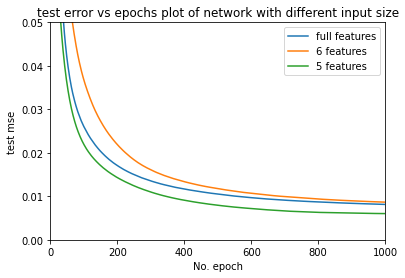

In [15]:
#Plot the test error of the 3 models on the same graph for comparison
# plot learning curves
plt.plot(results.history['val_mse'], label='full features')
plt.plot(results_6.history['val_mse'], label='6 features')
plt.plot(results_5.history['val_mse'], label='5 features')

plt.ylabel('test mse')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.title('test error vs epochs plot of network with different input size')
plt.savefig('./figures/2B_combined_test_error_not_zoomed.png')
plt.ylim(0,0.05)
plt.xlim(0,1000)
plt.savefig('./figures/2B_zoomed_combined_test_error.png')
plt.show()

In [16]:
#Shuffle test sample
idx = np.arange(X_test.shape[0])
np.random.shuffle(idx)
X_test_sample, Y_test_sample = X_test[idx], Y_test[idx]
X_test_sample = X_test_sample[:50,:]
Y_test_sample = Y_test_sample[:50,:]

X6_test_sample, X5_test_sample = X6_test[idx][:50,:],X5_test[idx][:50,:]

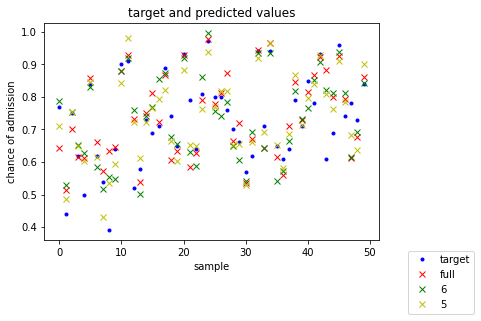

In [17]:
# plot trained and predicted points
predicted = model.predict(X_test_sample)
predicted_6 = model_6.predict(X6_test_sample)
predicted_5 = model_5.predict(X5_test_sample)
plt.plot(Y_test_sample, 'b.', label='target')
plt.plot(predicted, 'rx', label='full')
plt.plot(predicted_6, 'gx', label='6')
plt.plot(predicted_5, 'yx', label='5')
plt.xlabel('sample')
plt.ylabel('chance of admission')
plt.title('target and predicted values')
plt.savefig('./figures/2B_combined_target_predict.png')
plt.legend(bbox_to_anchor=(1.3,-.025))

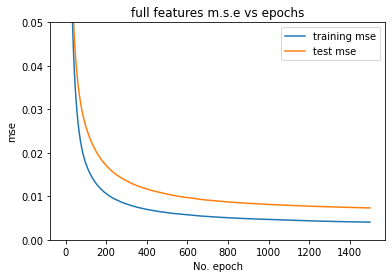

In [18]:
#Individual test error
# plot learning curves for full features
plt.plot(results.history['mse'], label='training mse')
plt.plot(results.history['val_mse'], label='test mse')
plt.ylabel('mse')
plt.xlabel('No. epoch')
plt.title('full features m.s.e vs epochs')
plt.legend(loc="upper right")
plt.savefig('./figures/2B_training_non_zoomed_full.png')
plt.ylim(0,0.05)
plt.savefig('./figures/2B_training_zoomed_full.png')
plt.show()

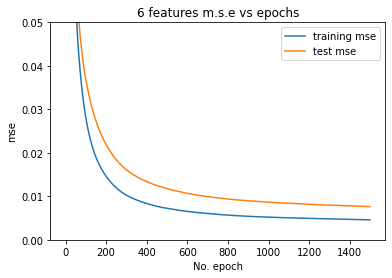

In [19]:
#Individual test error
# plot learning curves for full features
plt.plot(results_6.history['mse'], label='training mse')
plt.plot(results_6.history['val_mse'], label='test mse')
plt.ylabel('mse')
plt.xlabel('No. epoch')
plt.title('6 features m.s.e vs epochs')
plt.legend(loc="upper right")
plt.savefig('./figures/2B_training_non_zoomed_6.png')
plt.ylim(0,0.05)
plt.savefig('./figures/2B_training_zoomed_6.png')
plt.show()

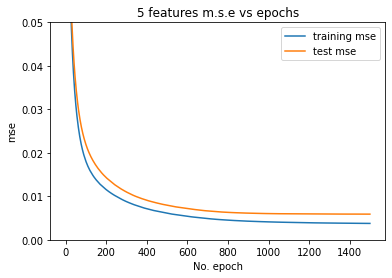

In [20]:
#Individual test error
# plot learning curves for full features
plt.plot(results_5.history['mse'], label='training mse')
plt.plot(results_5.history['val_mse'], label='test mse')
plt.ylabel('mse')
plt.xlabel('No. epoch')
plt.title('5 features m.s.e vs epochs')
plt.legend(loc="upper right")
plt.savefig('./figures/2B_training_non_zoomed_5.png')
plt.ylim(0,0.05)
plt.savefig('./figures/2B_training_zoomed_5.png')
plt.show()